In [4]:
import sys
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent if (Path.cwd().name == "notebooks") else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

try:
    df_feat_lib, FEATURES  
    print("Reusing df_feat_lib with", len(FEATURES), "features. Shape:", df_feat_lib.shape)
except NameError:
    from src.clean import basic_clean
    from src.features import build_min_features

    TRAIN_PATH = ROOT / "data" / "train.csv"
    print("Reading:", TRAIN_PATH.resolve())
    df = pd.read_csv(TRAIN_PATH)
    df_clean_lib = basic_clean(df, impute="median")
    df_feat_lib, FEATURES = build_min_features(df_clean_lib, include_bucket=True)
    print("Built df_feat_lib. Shape:", df_feat_lib.shape, "| Features:", FEATURES)

TARGET = "target"
assert TARGET in df_feat_lib.columns


Reusing df_feat_lib with 13 features. Shape: (5237892, 23)


In [5]:
import numpy as np
import pandas as pd

df_v2 = df_feat_lib.copy()


if {"bid_size", "ask_size"}.issubset(df_v2.columns):
    denom = (df_v2["bid_size"] + df_v2["ask_size"]).replace(0, np.nan)
    dir_ratio = (df_v2["bid_size"] - df_v2["ask_size"]) / denom
    df_v2["depth_imbalance_ratio"] = dir_ratio.fillna(0.0).clip(-1.0, 1.0)
else:
    df_v2["depth_imbalance_ratio"] = 0.0

if {"bid_ask_spread", "mid_price"}.issubset(df_v2.columns):
    eps = 1e-12
    df_v2["relative_spread"] = df_v2["bid_ask_spread"] / (df_v2["mid_price"].abs() + eps)
    df_v2["relative_spread"] = df_v2["relative_spread"].replace([np.inf, -np.inf], 0.0).fillna(0.0)
else:
    df_v2["relative_spread"] = 0.0


if {"signed_imbalance", "seconds_in_bucket"}.issubset(df_v2.columns):
    late_flag = (df_v2["seconds_in_bucket"] >= 480).astype("int8")  # 0..600 ~ last 10 mins; >=480 = last ~2 mins
    df_v2["late_signed_imbalance"] = df_v2["signed_imbalance"] * late_flag
else:
    df_v2["late_signed_imbalance"] = 0.0


NEW_FEATS = ["depth_imbalance_ratio", "relative_spread", "late_signed_imbalance"]
FEATURES_V2 = [c for c in FEATURES + NEW_FEATS if c in df_v2.columns]

print("Added features:", NEW_FEATS)
print("Total features V2:", len(FEATURES_V2))
print("First 5 rows (subset):")
display(df_v2[FEATURES_V2 + [TARGET]].head(5))


Added features: ['depth_imbalance_ratio', 'relative_spread', 'late_signed_imbalance']
Total features V2: 16
First 5 rows (subset):


,seconds_in_bucket,sec_bucket_group,bid_ask_spread,mid_price,signed_imbalance,near_price_minus_ref,far_price_minus_ref,matched_size,imbalance_size,bid_size,ask_size,reference_price,wap,depth_imbalance_ratio,relative_spread,late_signed_imbalance,target
0,0,0,0.000214,0.999919,3180602.69,0.000077,0.000071,13380276.64,3180602.69,60651.50,8493.03,0.999812,1.000000,0.754340,0.000214,0.0,-3.029704
1,10,0,0.000214,0.999919,1299772.70,-0.000137,-0.000143,15261106.63,1299772.70,13996.50,23519.16,1.000026,0.999892,-0.253832,0.000214,0.0,0.389814
2,20,0,0.000107,0.999866,1299772.70,-0.000030,-0.000036,15261106.63,1299772.70,4665.50,12131.60,0.999919,0.999842,-0.444487,0.000107,0.0,4.220009
3,30,0,0.000107,1.000080,1299772.70,-0.000244,-0.000250,15261106.63,1299772.70,55998.00,46203.30,1.000133,1.000085,0.095837,0.000107,0.0,5.450249
4,40,0,0.000214,1.000348,1218204.43,-0.000566,-0.000572,15342674.90,1218204.43,14655.95,26610.45,1.000455,1.000317,-0.289691,0.000214,0.0,3.169775


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import mean_absolute_error

DEBUG = True
SAMPLE_PER_DAY = 1500
N_SPLITS = 3
SEED = 42

# Sample down per day (keeps distribution; speeds up training)
if DEBUG and "date_id" in df_v2.columns:
    np.random.seed(SEED)
    idx = (
        df_v2.groupby("date_id", group_keys=False)
             .apply(lambda g: g.sample(min(SAMPLE_PER_DAY, len(g)), random_state=SEED))
             .index
    )
    data_used = df_v2.loc[idx].reset_index(drop=True)
else:
    data_used = df_v2

print("Rows used:", len(data_used), "(DEBUG:", DEBUG, ")")

# Choose a fast model (prefer LightGBM if installed)
MODEL_NAME = None
try:
    import lightgbm as lgb
    from lightgbm import LGBMRegressor
    def make_model():
        return LGBMRegressor(
            n_estimators=1500,
            learning_rate=0.07,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=SEED
        )
    MODEL_NAME = "LightGBM"
except Exception:
    try:
        from sklearn.ensemble import HistGradientBoostingRegressor
        def make_model():
            return HistGradientBoostingRegressor(
                learning_rate=0.1,
                max_iter=500,
                early_stopping=True,
                random_state=SEED
            )
        MODEL_NAME = "HistGBR"
    except Exception:
        from sklearn.ensemble import RandomForestRegressor
        def make_model():
            return RandomForestRegressor(
                n_estimators=120,
                n_jobs=-1,
                random_state=SEED
            )
        MODEL_NAME = "RandomForest"

print("Using model:", MODEL_NAME)

X = data_used[FEATURES_V2].values
y = data_used[TARGET].values
groups = data_used["date_id"].values if "date_id" in data_used.columns else None

cv = GroupKFold(n_splits=N_SPLITS) if groups is not None else KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_mae_v2, models_v2 = [], []

for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y, groups), 1):
    X_tr, y_tr = X[tr_idx], y[tr_idx]
    X_va, y_va = X[va_idx], y[va_idx]
    model = make_model()

    if MODEL_NAME == "LightGBM":
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_va, y_va)],
            eval_metric="mae",
            callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
        )
    else:
        model.fit(X_tr, y_tr)

    pred = model.predict(X_va)
    mae = mean_absolute_error(y_va, pred)
    fold_mae_v2.append(mae)
    models_v2.append(model)
    print(f"Fold {fold} {MODEL_NAME} MAE (v2): {mae:.5f}")

cv_mean_v2, cv_std_v2 = float(np.mean(fold_mae_v2)), float(np.std(fold_mae_v2))
print(f"\nCV MAE (v2): {cv_mean_v2:.5f} ± {cv_std_v2:.5f} ({N_SPLITS} folds)")


/var/folders/xx/w12875ds6blcc9p0ljq82tdw0000gn/T/ipykernel_66548/2605036863.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(SAMPLE_PER_DAY, len(g)), random_state=SEED))


Rows used: 721500 (DEBUG: True )
Using model: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3628
[LightGBM] [Info] Number of data points in the train set: 480000, number of used features: 16
[LightGBM] [Info] Start training from score -0.028767


/Users/krithiktoure/Desktop/DS Project 1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 1 LightGBM MAE (v2): 6.39989
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3628
[LightGBM] [Info] Number of data points in the train set: 481500, number of used features: 16
[LightGBM] [Info] Start training from score -0.025586


/Users/krithiktoure/Desktop/DS Project 1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 2 LightGBM MAE (v2): 6.30928
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3628
[LightGBM] [Info] Number of data points in the train set: 481500, number of used features: 16
[LightGBM] [Info] Start training from score -0.044745


/Users/krithiktoure/Desktop/DS Project 1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 3 LightGBM MAE (v2): 6.32988

CV MAE (v2): 6.34635 ± 0.03878 (3 folds)


matched_size             412.0
bid_ask_spread           402.3
seconds_in_bucket        368.7
near_price_minus_ref     320.3
relative_spread          313.7
wap                      302.7
depth_imbalance_ratio    288.3
reference_price          282.7
bid_size                 268.7
ask_size                 259.0
dtype: float64


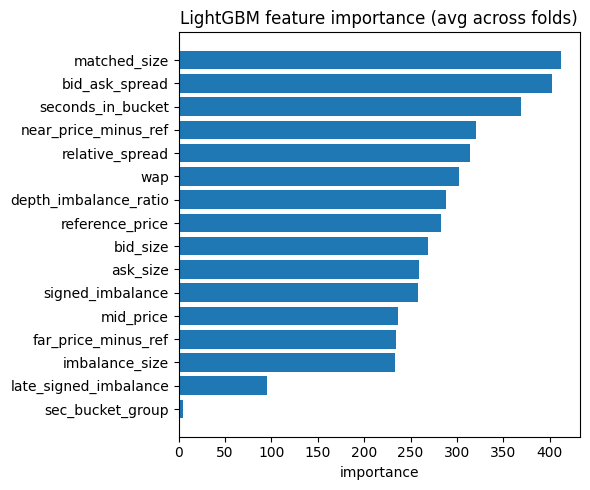

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) stack each fold's importances into a 2D array
imp_matrix = np.vstack([m.feature_importances_ for m in models_v2])

# 2) take the mean importance for each feature across folds
imp_mean = imp_matrix.mean(axis=0)

# 3) turn into a Series indexed by feature name and sort
fi = pd.Series(imp_mean, index=FEATURES_V2).sort_values(ascending=False)

# 4) print the top 10 (numbers rounded) for quick reading
print(fi.head(10).round(1))

# 5) plot top 20 as a horizontal bar chart
plt.figure(figsize=(6,5))
top = fi.head(20)[::-1]           # reverse so biggest is at the top of the plot
plt.barh(top.index, top.values)
plt.title("LightGBM feature importance (avg across folds)")
plt.xlabel("importance")
plt.tight_layout()
plt.show()

In [8]:
from pathlib import Path
import json
import joblib
import numpy as np

ART = ROOT / "artifacts"
ART.mkdir(exist_ok=True)

# pick the best fold (lowest MAE)
best_idx_v2 = int(np.argmin(fold_mae_v2))
best_model_v2 = models_v2[best_idx_v2]

# save model
model_path = ART / f"lgbm_v2_best_fold{best_idx_v2+1}.pkl"
joblib.dump(best_model_v2, model_path)

# save features used
(ART / "features_v2.json").write_text(json.dumps(FEATURES_V2))

# save a tiny CV report
cv_meta_v2 = {
    "model": "LightGBM",
    "feature_set": "v2",
    "best_fold": best_idx_v2 + 1,
    "fold_mae": [float(x) for x in fold_mae_v2],
    "cv_mae_mean": float(cv_mean_v2),
    "cv_mae_std": float(cv_std_v2),
    "n_features": int(len(FEATURES_V2))
}
(ART / "cv_meta_v2.json").write_text(json.dumps(cv_meta_v2, indent=2))

print("Saved:", model_path.name, "features_v2.json", "cv_meta_v2.json")

Saved: lgbm_v2_best_fold2.pkl features_v2.json cv_meta_v2.json


In [10]:
import numpy as np
import pandas as pd

# Always sort so "rolling" moves forward in time
df_v3 = df_v2.sort_values(["date_id", "stock_id", "seconds_in_bucket"]).reset_index(drop=True).copy()

# Group per (day, stock) so rolls only use that stock's past within that day
grp = df_v3.groupby(["date_id", "stock_id"], sort=False)

# 1) Rolling mean of signed_imbalance over the LAST 60s (PAST ONLY)
#    shift(1) removes the current second to avoid leakage
df_v3["si_roll_mean_60"] = (
    grp["signed_imbalance"]
    .transform(lambda s: s.shift(1).rolling(window=60, min_periods=5).mean())
    .fillna(0.0)
    .astype("float32")
)

# 2) 1-second WAP return in bps, then rolling std over LAST 60s (PAST ONLY)
wap_prev = grp["wap"].shift(1)
ret1s = (df_v3["wap"] - wap_prev) / wap_prev
df_v3["wap_ret1s"] = (ret1s * 1e4).fillna(0.0).astype("float32")

df_v3["ret1s_roll_std_60"] = (
    df_v3.groupby(["date_id", "stock_id"])["wap_ret1s"]
    .transform(lambda s: s.shift(1).rolling(window=60, min_periods=5).std())
    .fillna(0.0)
    .astype("float32")
)

# Build feature list
NEW_ROLL = ["si_roll_mean_60", "ret1s_roll_std_60"]
FEATURES_V3 = [c for c in FEATURES_V2 + NEW_ROLL if c in df_v3.columns]

print("Added rolling features:", NEW_ROLL)
print("Total features V3:", len(FEATURES_V3))
display(df_v3[FEATURES_V3 + [TARGET]].head())


Added rolling features: ['si_roll_mean_60', 'ret1s_roll_std_60']
Total features V3: 18


,seconds_in_bucket,sec_bucket_group,bid_ask_spread,mid_price,signed_imbalance,near_price_minus_ref,far_price_minus_ref,matched_size,imbalance_size,bid_size,ask_size,reference_price,wap,depth_imbalance_ratio,relative_spread,late_signed_imbalance,si_roll_mean_60,ret1s_roll_std_60,target
0,0,0,0.000214,0.999919,3180602.69,0.000077,0.000071,13380276.64,3180602.69,60651.50,8493.03,0.999812,1.000000,0.754340,0.000214,0.0,0.0,0.0,-3.029704
1,10,0,0.000214,0.999919,1299772.70,-0.000137,-0.000143,15261106.63,1299772.70,13996.50,23519.16,1.000026,0.999892,-0.253832,0.000214,0.0,0.0,0.0,0.389814
2,20,0,0.000107,0.999866,1299772.70,-0.000030,-0.000036,15261106.63,1299772.70,4665.50,12131.60,0.999919,0.999842,-0.444487,0.000107,0.0,0.0,0.0,4.220009
3,30,0,0.000107,1.000080,1299772.70,-0.000244,-0.000250,15261106.63,1299772.70,55998.00,46203.30,1.000133,1.000085,0.095837,0.000107,0.0,0.0,0.0,5.450249
4,40,0,0.000214,1.000348,1218204.43,-0.000566,-0.000572,15342674.90,1218204.43,14655.95,26610.45,1.000455,1.000317,-0.289691,0.000214,0.0,0.0,0.0,3.169775


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import mean_absolute_error

# Use the SAME sampled rows as earlier if we had 'data_used' (from v2 cell),
# so we compare fairly; otherwise, do the usual debug sampling.
if "data_used" in globals():
    data_used_v3 = df_v3.loc[data_used.index].reset_index(drop=True)
else:
    np.random.seed(SEED)
    if DEBUG and "date_id" in df_v3.columns:
        idx_v3 = (
            df_v3.groupby("date_id", group_keys=False)
                 .apply(lambda g: g.sample(min(SAMPLE_PER_DAY, len(g)), random_state=SEED))
                 .index
        )
        data_used_v3 = df_v3.loc[idx_v3].reset_index(drop=True)
    else:
        data_used_v3 = df_v3

print("Rows used (v3):", len(data_used_v3), "(DEBUG:", DEBUG, ")")
print("Using model:", MODEL_NAME)

X = data_used_v3[FEATURES_V3].values
y = data_used_v3[TARGET].values
groups = data_used_v3["date_id"].values if "date_id" in data_used_v3.columns else None

cv = GroupKFold(n_splits=N_SPLITS) if groups is not None else KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_mae_v3, models_v3 = [], []

for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y, groups), 1):
    model = make_model()

    if MODEL_NAME == "LightGBM":
        model.fit(
            X[tr_idx], y[tr_idx],
            eval_set=[(X[va_idx], y[va_idx])],
            eval_metric="mae",
            callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
        )
    else:
        model.fit(X[tr_idx], y[tr_idx])

    pred = model.predict(X[va_idx])
    mae = mean_absolute_error(y[va_idx], pred)
    fold_mae_v3.append(mae)
    models_v3.append(model)
    print(f"Fold {fold} {MODEL_NAME} MAE (v3): {mae:.5f}")

cv_mean_v3, cv_std_v3 = float(np.mean(fold_mae_v3)), float(np.std(fold_mae_v3))
print(f"\nCV MAE (v3): {cv_mean_v3:.5f} ± {cv_std_v3:.5f} ({N_SPLITS} folds)")

# Compare to v2 if available
if "cv_mean_v2" in globals():
    delta = cv_mean_v2 - cv_mean_v3
    print(f"Δ vs v2 (positive = v3 better): {delta:+.5f}")


Rows used (v3): 721500 (DEBUG: True )
Using model: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4138
[LightGBM] [Info] Number of data points in the train set: 487970, number of used features: 18
[LightGBM] [Info] Start training from score -0.032001


/Users/krithiktoure/Desktop/DS Project 1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 1 LightGBM MAE (v3): 5.39318
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4138
[LightGBM] [Info] Number of data points in the train set: 477510, number of used features: 18
[LightGBM] [Info] Start training from score -0.128403


/Users/krithiktoure/Desktop/DS Project 1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 2 LightGBM MAE (v3): 5.22124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4138
[LightGBM] [Info] Number of data points in the train set: 477520, number of used features: 18
[LightGBM] [Info] Start training from score -0.069128
Fold 3 LightGBM MAE (v3): 5.10931

CV MAE (v3): 5.24124 ± 0.11675 (3 folds)
Δ vs v2 (positive = v3 better): +1.10511


/Users/krithiktoure/Desktop/DS Project 1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [16]:
# 0) Make sure the project root is importable
import sys, importlib, inspect
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# 1) Reload the module you just edited (forces Jupyter to see the current file)
import src.features as F
importlib.invalidate_caches()
F = importlib.reload(F)

print("Loaded from:", F.__file__)
print("Has build_features_v3?:", hasattr(F, "build_features_v3"))
print("Builders exported:", [n for n in dir(F) if n.startswith("build_")])

Loaded from: /Users/krithiktoure/Desktop/DS Project 1/src/features.py
Has build_features_v3?: True
Builders exported: ['build_features_v2', 'build_features_v3', 'build_min_features']


In [17]:
df_v3, FEATURES_V3 = F.build_features_v3(df_clean_lib, include_bucket=True)
print("df_v3:", df_v3.shape, "| n_features:", len(FEATURES_V3))

# quick sanity checks
print("Any NaNs in features?", df_v3[FEATURES_V3].isna().any().any())
display(df_v3[FEATURES_V3 + ["target"]].head())

df_v3: (5237892, 29) | n_features: 18
Any NaNs in features? False


,seconds_in_bucket,sec_bucket_group,bid_ask_spread,mid_price,signed_imbalance,near_price_minus_ref,far_price_minus_ref,matched_size,imbalance_size,bid_size,ask_size,reference_price,wap,depth_imbalance_ratio,relative_spread,late_signed_imbalance,si_roll_mean_60,ret1s_roll_std_60,target
0,0,0,0.000214,0.999919,3180602.69,0.000077,0.000071,13380276.64,3180602.69,60651.50,8493.03,0.999812,1.000000,0.754340,0.000214,0.0,0.0,0.0,-3.029704
1,10,0,0.000214,0.999919,1299772.70,-0.000137,-0.000143,15261106.63,1299772.70,13996.50,23519.16,1.000026,0.999892,-0.253832,0.000214,0.0,0.0,0.0,0.389814
2,20,0,0.000107,0.999866,1299772.70,-0.000030,-0.000036,15261106.63,1299772.70,4665.50,12131.60,0.999919,0.999842,-0.444487,0.000107,0.0,0.0,0.0,4.220009
3,30,0,0.000107,1.000080,1299772.70,-0.000244,-0.000250,15261106.63,1299772.70,55998.00,46203.30,1.000133,1.000085,0.095837,0.000107,0.0,0.0,0.0,5.450249
4,40,0,0.000214,1.000348,1218204.43,-0.000566,-0.000572,15342674.90,1218204.43,14655.95,26610.45,1.000455,1.000317,-0.289691,0.000214,0.0,0.0,0.0,3.169775


In [18]:
from src.features import build_features_v3
df_v3, FEATURES_V3 = build_features_v3(df_clean_lib, include_bucket=True)
print("df_v3:", df_v3.shape, "| n_features:", len(FEATURES_V3))


df_v3: (5237892, 29) | n_features: 18


In [19]:
import numpy as np
from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import mean_absolute_error

# Use the exact same rows as earlier (if available) for apples-to-apples
if "data_used" in globals():
    data_used_v3 = df_v3.loc[data_used.index].reset_index(drop=True)
else:
    np.random.seed(SEED)
    if DEBUG and "date_id" in df_v3.columns:
        idx_v3 = (
            df_v3.groupby("date_id", group_keys=False)
                 .apply(lambda g: g.sample(min(SAMPLE_PER_DAY, len(g)), random_state=SEED))
                 .index
        )
        data_used_v3 = df_v3.loc[idx_v3].reset_index(drop=True)
    else:
        data_used_v3 = df_v3

print("Rows used (v3):", len(data_used_v3), "(DEBUG:", DEBUG, ")")
print("Using model:", MODEL_NAME)

X = data_used_v3[FEATURES_V3].values
y = data_used_v3[TARGET].values
groups = data_used_v3["date_id"].values if "date_id" in data_used_v3.columns else None

cv = GroupKFold(n_splits=N_SPLITS) if groups is not None else KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

fold_mae_v3, models_v3 = [], []
for fold, (tr_idx, va_idx) in enumerate(cv.split(X, y, groups), 1):
    model = make_model()
    if MODEL_NAME == "LightGBM":
        model.fit(
            X[tr_idx], y[tr_idx],
            eval_set=[(X[va_idx], y[va_idx])],
            eval_metric="mae",
            callbacks=[lgb.early_stopping(stopping_rounds=80, verbose=False)]
        )
    else:
        model.fit(X[tr_idx], y[tr_idx])

    pred = model.predict(X[va_idx])
    mae = mean_absolute_error(y[va_idx], pred)
    fold_mae_v3.append(mae)
    models_v3.append(model)
    print(f"Fold {fold} {MODEL_NAME} MAE (v3): {mae:.5f}")

cv_mean_v3, cv_std_v3 = float(np.mean(fold_mae_v3)), float(np.std(fold_mae_v3))
print(f"\nCV MAE (v3): {cv_mean_v3:.5f} ± {cv_std_v3:.5f}")


Rows used (v3): 721500 (DEBUG: True )
Using model: LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005304 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4138
[LightGBM] [Info] Number of data points in the train set: 487970, number of used features: 18
[LightGBM] [Info] Start training from score -0.032001


/Users/krithiktoure/Desktop/DS Project 1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 1 LightGBM MAE (v3): 5.39318
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4138
[LightGBM] [Info] Number of data points in the train set: 477510, number of used features: 18
[LightGBM] [Info] Start training from score -0.128403


/Users/krithiktoure/Desktop/DS Project 1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 2 LightGBM MAE (v3): 5.22124
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4138
[LightGBM] [Info] Number of data points in the train set: 477520, number of used features: 18
[LightGBM] [Info] Start training from score -0.069128


/Users/krithiktoure/Desktop/DS Project 1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 3 LightGBM MAE (v3): 5.10931

CV MAE (v3): 5.24124 ± 0.11675


In [20]:
from pathlib import Path
import json, joblib, numpy as np

ART = ROOT / "artifacts"
ART.mkdir(exist_ok=True)

best_idx_v3 = int(np.argmin(fold_mae_v3))
joblib.dump(models_v3[best_idx_v3], ART / f"lgbm_v3_best_fold{best_idx_v3+1}.pkl")
(ART / "features_v3.json").write_text(json.dumps(FEATURES_V3))
(ART / "cv_meta_v3.json").write_text(json.dumps({
    "model": "LightGBM",
    "feature_set": "v3",
    "best_fold": best_idx_v3 + 1,
    "fold_mae": [float(x) for x in fold_mae_v3],
    "cv_mae_mean": float(cv_mean_v3),
    "cv_mae_std": float(cv_std_v3),
    "n_features": int(len(FEATURES_V3)),
}, indent=2))
print("Saved v3 artifacts.")


Saved v3 artifacts.
